In [1]:
import numpy as np
from tqdm import tqdm
import math
from sklearn.metrics.pairwise import cosine_similarity
import scienceplots 
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('science')
from copy import deepcopy
mpl.rcParams['figure.dpi'] = 300

In [2]:
import lib.python.lib_FHRR_Loihi as lib
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps

## Plot function

In [3]:
def plot_multiple_box_plots(data_sets, x_title="X Values", y_title="Y Values", title="", show_box_plots=True, label_prefix="", y_limits=None, x_limits=None, figsize=(10, 6), show_outliers=False):
    """
    Plots multiple sets of customized black and white box plots for each x value with multiple y values,
    indicates outliers, and adds a line graph connecting the means of y values for each dataset.

    Parameters:
    data_sets (list of dicts): List of dictionaries, each containing 'x_values', 'y_values', and 'title' keys.
                               Each dictionary represents a dataset.
    x_title (str): Label for the x-axis.
    y_title (str): Label for the y-axis.
    title (str): Overall title of the plot.
    show_box_plots (bool): If True, display box plots. If False, only plot the means.
    y_limits (tuple): Optional parameter to set the y-axis limits. Should be a tuple (y_min, y_max).
    """
    fig, ax = plt.subplots(figsize=figsize)

    plt.rcParams["figure.figsize"] = [5.00, 5.50]
    plt.rcParams["figure.autolayout"] = True

    colors  = ['black', 'blue', 'green', 'red', 'purple', 'orange']
    markers = ['.','x', 'P', 'X', 'o', 'D', '*']

    for idx, data_set in enumerate(data_sets):
        x_values = data_set['x_values']
        y_values = data_set['y_values']
        dataset_title = data_set.get('title', f'Dataset {idx + 1}')
        color = colors[idx % len(colors)]
        marker = markers[idx % len(markers)]
        
        if show_box_plots:
            # Create the box plot
            boxplot = ax.boxplot(y_values, positions=x_values, patch_artist=False, showmeans=True, meanline=True,
                                 showfliers=show_outliers,
                                 flierprops=dict(marker='x', color=color, markersize=5), boxprops=dict(color=color),
                                 whiskerprops=dict(color=color), capprops=dict(color=color), medianprops=dict(color=color))
        
        # Calculate means of y values
        means = [np.mean(y) for y in y_values]
        
        # Plot the line graph connecting the means
        label_txt = label_prefix + f' {dataset_title}'
        ax.plot(x_values, means, color=color, linestyle='-', marker=marker, markerfacecolor='none', label=label_txt)

    # Set the x-axis labels
    ax.set_xticks(x_values)
    ax.set_xticklabels([str(x) for x in x_values])

    # Set labels and title
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)

    # Set y-axis limits if provided
    if y_limits is not None:
        ax.set_ylim(y_limits)

    if x_limits is not None:
        ax.set_xlim(x_limits)

    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()


## Different neural codes


In [4]:
def rate_encode(values, duration):
    """
    Encodes input values into spike trains using rate coding.
    The firing rate of the neurons corresponds to the normalized value of the input.

    Args:
        values (numpy.ndarray): Array of input values.
        duration (int): Duration of the spike train.

    Returns:
        tuple: A tuple containing spike trains, minimum value, and maximum value.
    """
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    spike_trains = np.random.binomial(1, normalized_values, (duration, len(values)))
    return spike_trains, min_val, max_val


def rate_decode(spike_trains, duration, min_val, max_val):
    """
    Decodes spike trains back into original values using rate coding.
    The decoded value is proportional to the spike rate.

    Args:
        spike_trains (numpy.ndarray): Encoded spike trains.
        duration (int): Duration of the spike train.
        min_val (float): Minimum value used for normalization.
        max_val (float): Maximum value used for normalization.

    Returns:
        numpy.ndarray: Decoded original values.
    """
    spike_counts = np.sum(spike_trains, axis=0)
    decoded_values = spike_counts / duration
    original_values = decoded_values * (max_val - min_val) + min_val
    return original_values


def rate_decode_get_activity(spike_trains, duration, min_val, max_val):
    """
    Calculates the total spike activity across all neurons.

    Args:
        spike_trains (numpy.ndarray): Encoded spike trains.
        duration (int): Duration of the spike train.
        min_val (float): Minimum value used for normalization.
        max_val (float): Maximum value used for normalization.

    Returns:
        int: Total number of spikes across all neurons.
    """
    spike_counts = np.sum(np.sum(spike_trains, axis=0))
    return spike_counts


# Encoding Exact
def rate_encode_exact(values, duration):
    """
    Encodes input values into spike trains using exact rate coding.
    The number of spikes is directly proportional to the normalized input value.

    Args:
        values (numpy.ndarray): Array of input values.
        duration (int): Duration of the spike train.

    Returns:
        tuple: A tuple containing spike trains, minimum value, and maximum value.
    """
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    spike_trains = np.zeros((duration, len(values)))
    for i, value in enumerate(normalized_values):
        num_spikes = int(value * duration)
        spike_indices = np.linspace(0, duration-1, num_spikes, dtype=int)
        spike_trains[spike_indices, i] = 1
    return spike_trains, min_val, max_val


def rate_decode_exact(spike_trains, duration, min_val, max_val):
    """
    Decodes spike trains back into original values using exact rate coding.

    Args:
        spike_trains (numpy.ndarray): Encoded spike trains.
        duration (int): Duration of the spike train.
        min_val (float): Minimum value used for normalization.
        max_val (float): Maximum value used for normalization.

    Returns:
        numpy.ndarray: Decoded original values.
    """
    spike_counts = np.sum(spike_trains, axis=0)
    decoded_values = spike_counts / duration
    original_values = decoded_values * (max_val - min_val) + min_val
    return original_values


# Encoding
def latency_encode(values, duration):
    """
    Encodes input values into spike trains using latency coding.
    The time of the first spike is inversely proportional to the input value.

    Args:
        values (numpy.ndarray): Array of input values.
        duration (int): Duration of the spike train.

    Returns:
        tuple: A tuple containing spike trains, minimum value, and maximum value.
    """
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    spike_trains = np.zeros((duration, len(values)))
    for i, value in enumerate(normalized_values):
        spike_time = int((1 - value) * (duration - 1))
        spike_trains[spike_time, i] = 1
    return spike_trains, min_val, max_val


def latency_decode(spike_trains, duration, min_val, max_val):
    """
    Decodes spike trains back into original values using latency coding.
    The decoded value is inversely proportional to the time of the first spike.

    Args:
        spike_trains (numpy.ndarray): Encoded spike trains.
        duration (int): Duration of the spike train.
        min_val (float): Minimum value used for normalization.
        max_val (float): Maximum value used for normalization.

    Returns:
        numpy.ndarray: Decoded original values.
    """
    first_spike_times = np.argmax(spike_trains, axis=0)
    normalized_values = 1 - (first_spike_times / (duration - 1))
    original_values = normalized_values * (max_val - min_val) + min_val
    return original_values


def preprocess_latency_encode_vec_TTFS(vec, v_th, sim_time):
    """
    Preprocesses input vectors for latency encoding using Time-to-First-Spike (TTFS).

    Args:
        vec (numpy.ndarray): Input vector.
        v_th (float): Threshold value for encoding.
        sim_time (float): Simulation time.

    Returns:
        numpy.ndarray: Preprocessed latency values for encoding.
    """
    return v_th * (2 * math.pi) / (vec * sim_time)


def preprocess_latency_decode_vec_TTFS(vec, v_th, sim_time):
    """
    Preprocesses decoded vectors for latency decoding using Time-to-First-Spike (TTFS).

    Args:
        vec (numpy.ndarray): Decoded vector.
        v_th (float): Threshold value used during encoding.
        sim_time (float): Simulation time.

    Returns:
        numpy.ndarray: Preprocessed decoded values.
    """
    return (v_th * vec) / (2 * math.pi)


def preprocess_latency_encode_vec_Phase(vec, v_th, sim_time):
    """
    Preprocesses input vectors for latency encoding using phase-based representation.

    Args:
        vec (numpy.ndarray): Input vector.
        v_th (float): Threshold value for encoding.
        sim_time (float): Simulation time.

    Returns:
        numpy.ndarray: Preprocessed latency values for phase-based encoding.
    """
    return (v_th * 2 * math.pi) / (sim_time * vec)


## PARAMETER SET

In [6]:
sim_time = 100
v_th = 20
rv_repeat = 1

dimension_list = [10, 100, 1000]#, 10000, 100000]

## Experiment 1: Reconstruction similarity of random vectors and activity of different neural codes


In [7]:
full_rslt = []
full_actv = []

sim_rslt = []
act_rslt = []

### TTFS Encoding (LIF)


In [8]:
for dimensions in tqdm(dimension_list):
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        error_percentage = 0.0498 # To make v_th=120 for a nice figure
        # 0.06283 = 2 pi * 1%
        # v_th, _ = lib.set_params_auto(error_percentage,0.06283) # Last param is dummy as we select the timesteps manually here
        lib.set_params_manual(v_th, sim_time)
        
        encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_TTFS(rv1, v_th, sim_time))
        decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())
        
        raw_rslt  = decoder.get_decoded_value()
        rv_rslt_act.append( np.sum(decoder.get_spike_count()) )
        
        decoder.stop()

        raw_rslt_convert =  (v_th * 2*math.pi) / (sim_time * raw_rslt)
        
        rslt = cosine_similarity([rv1], [raw_rslt_convert])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    act_rslt.append(rv_rslt_act)
    
full_rslt.append( {'title':'TTFS', 'x_values':dimension_list, 'y_values':sim_rslt} )
full_actv.append( {'title':'TTFS', 'x_values':dimension_list, 'y_values':act_rslt} )

100%|██████████| 3/3 [00:11<00:00,  3.84s/it]


### Poisson Rate Encoding


In [9]:
sim_rslt = []
act_rslt = []
for dimensions in tqdm(dimension_list):
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        # Encode
        spike_trains, min_val, max_val = rate_encode(rv1, sim_time)
        # print("Spike Trains:\n", spike_trains)
        
        # Decode
        decoded_values = rate_decode(spike_trains, sim_time, min_val, max_val)
        rv_rslt_act.append( rate_decode_get_activity(spike_trains, sim_time, min_val, max_val) )
        
        rslt = cosine_similarity([rv1], [decoded_values])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    act_rslt.append(rv_rslt_act)
    
full_rslt.append( {'title':'Poisson Rate Encoding', 'x_values':dimension_list, 'y_values':sim_rslt} )
full_actv.append( {'title':'Poisson Rate Encoding', 'x_values':dimension_list, 'y_values':act_rslt} )

100%|██████████| 3/3 [00:00<00:00, 374.94it/s]


### Rate Encoding (LIF)

In [10]:
sim_rslt = []
act_rslt = []

''' Calibration to find how many spikes will I get for the Max value. Depends on the timesteps, Vth'''

rv1 = np.array([2*math.pi])

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

spike_count = decoder.get_spike_count()

max_count = spike_count[0]
'''
But calibration is mandatory as after the calibration calculation, it is just a scaling of the spike count vector, which will not 
affect the cosine similarity.
'''

for dimensions in tqdm(dimension_list):
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        encoder  = lib.FHRR_Encoder(vec = rv1)
        decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())
        
        spike_count = decoder.get_spike_count()
        rv_rslt_act.append( np.sum(decoder.get_spike_count()) )
        
        decoder.stop()

        decoded_vec = spike_count / max_count * (2*math.pi)
        
        rslt = cosine_similarity([rv1], [decoded_vec])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    act_rslt.append(rv_rslt_act)
    
full_rslt.append( {'title':'Rate Encoding', 'x_values':dimension_list, 'y_values':sim_rslt} )
full_actv.append( {'title':'Rate Encoding', 'x_values':dimension_list, 'y_values':act_rslt} )

100%|██████████| 3/3 [00:09<00:00,  3.20s/it]


### Phase Encoding (LIF)


In [11]:
sim_rslt = []
act_rslt = []

rv1 = np.array([2*math.pi])
        
encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_Phase(rv1, v_th, sim_time))
decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())

decoded = decoder.get_spike_period()

decoder.stop()

max_decoded = decoded[0]

for dimensions in tqdm(dimension_list):
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_Phase(rv1, v_th, sim_time))
        decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())
        
        decoded = decoder.get_spike_period()
        rv_rslt_act.append( np.sum(decoder.get_spike_count()) * 2 ) # Assuming two cycles of the phase
        
        decoder.stop()

        decoded_vec = decoded / max_decoded * (2*math.pi) # max_decoded means the timestep for 2*pi
        
        rslt = cosine_similarity([rv1], [decoded_vec])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    act_rslt.append(rv_rslt_act)
    
full_rslt.append( {'title':'Phase Encoding', 'x_values':dimension_list, 'y_values':sim_rslt} )
full_actv.append( {'title':'Phase Encoding', 'x_values':dimension_list, 'y_values':act_rslt} )

100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


In [12]:
P = math.pi
rv1 = np.array([2*P, P, P/2, P/4])
        
encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_Phase(rv1, v_th, sim_time))
decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())

decoded = decoder.get_spike_period()
rv_rslt_act.append( np.sum(decoder.get_spike_count()) )

decoder.stop()

decoded_vec = decoded / max_decoded * (2*math.pi) # max_decoded means the timestep for 2*pi

rslt = cosine_similarity([rv1], [decoded_vec])[0][0]

In [13]:
full_rslt_log = deepcopy(full_rslt)
full_actv_log = deepcopy(full_actv)

In [14]:
for it in full_rslt_log:
    it['x_values'] = [math.log10(dim) for dim in it['x_values']]

In [15]:
for it in full_actv_log:
    it['y_values'] = [[np.log10(item[0])] for item in it['y_values']]
    it['x_values'] = [math.log10(dim) for dim in it['x_values']]

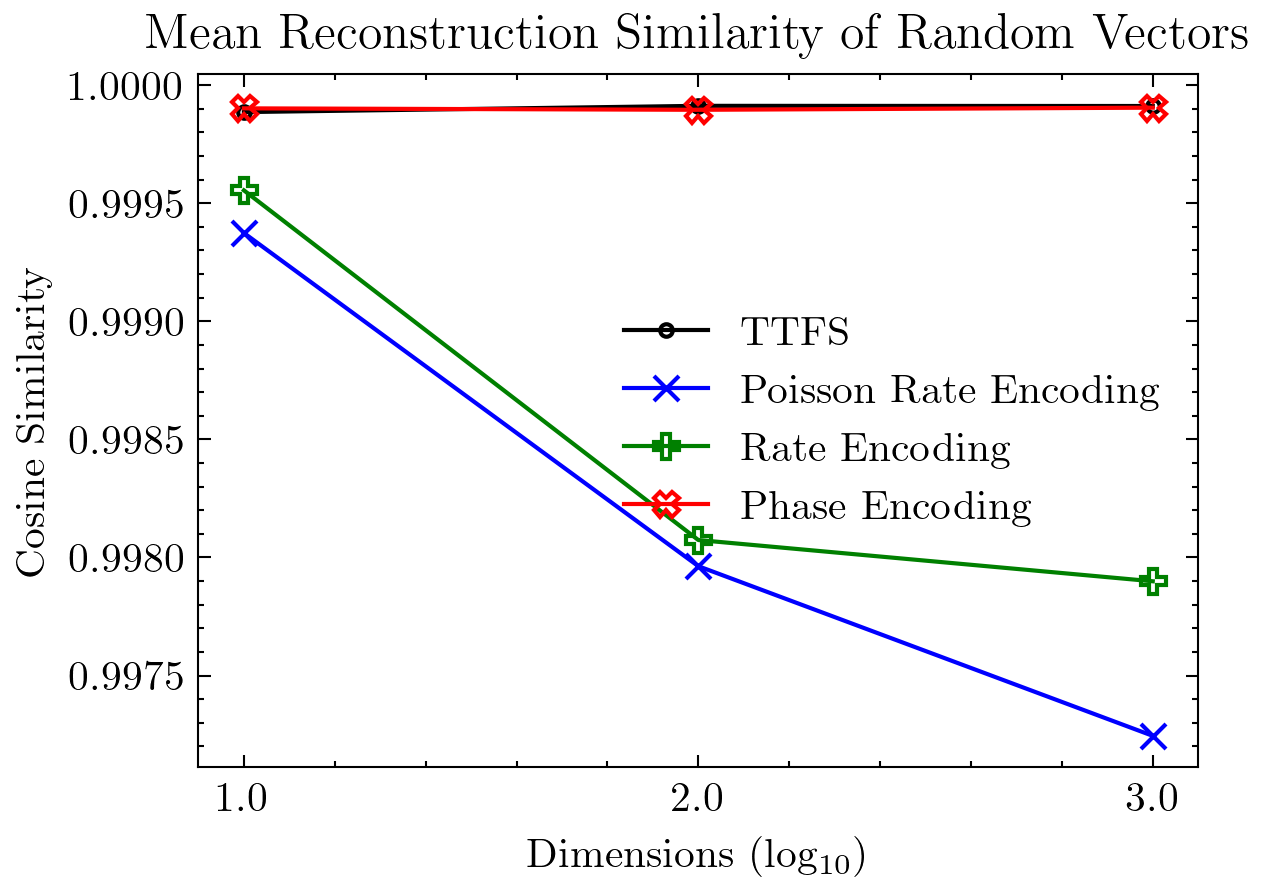

In [16]:
plot_multiple_box_plots(full_rslt_log, "Dimensions (log$_{10}$)", "Cosine Similarity", "Mean Reconstruction Similarity of Random Vectors", False
                        , label_prefix="", figsize=(4.3,3))# x_limits=(-10,10050), y_limits=(0.9995, 1))

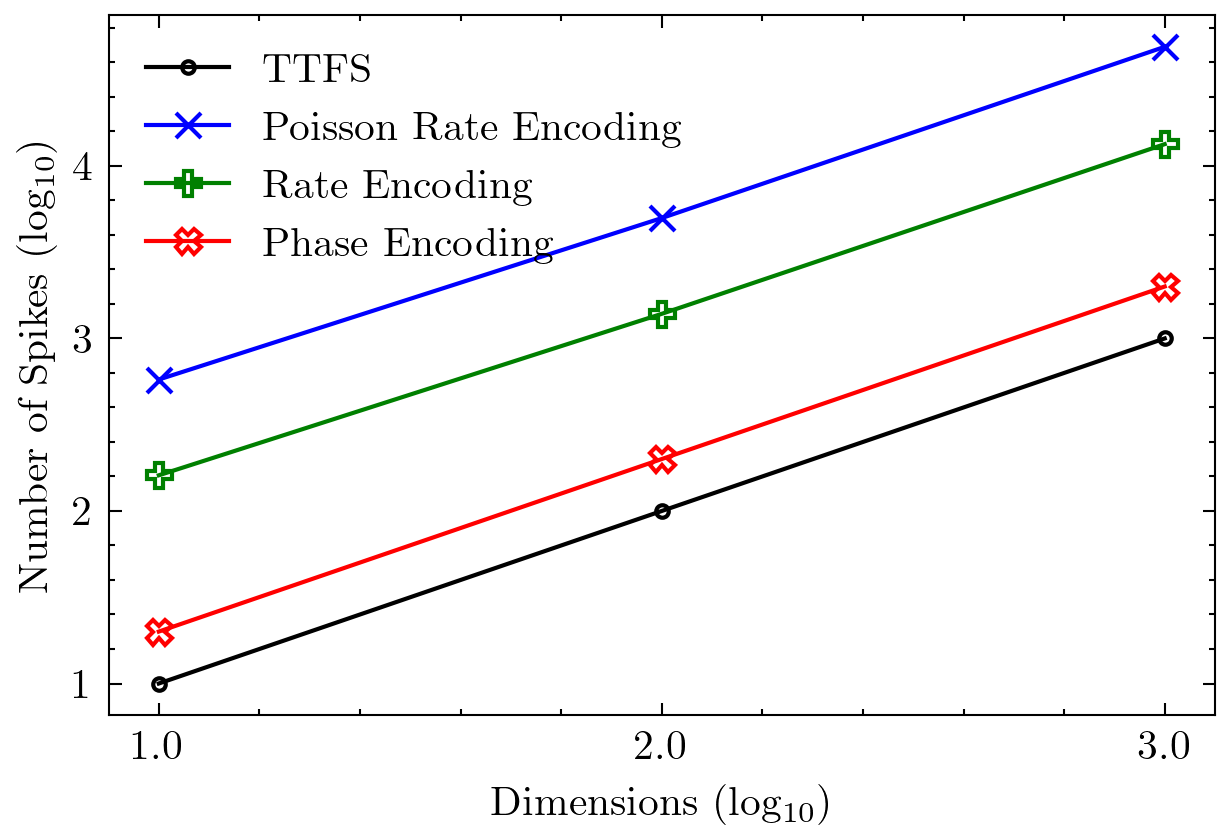

In [17]:
plot_multiple_box_plots(full_actv_log, "Dimensions (log$_{10}$)", "Number of Spikes (log$_{10}$)", "", False, label_prefix="", figsize=(4.3,3))# x_limits=(-10,10050), y_limits=(0.9995, 1))

In [18]:
result = []

for rslt, actv in zip(full_rslt_log, full_actv_log):
    title = rslt['title']
    x_values = rslt['x_values']
    y_values = [[r[0] / a[0]] for r, a in zip(rslt['y_values'], actv['y_values'])]
    result.append({'title': title, 'x_values': x_values, 'y_values': y_values})

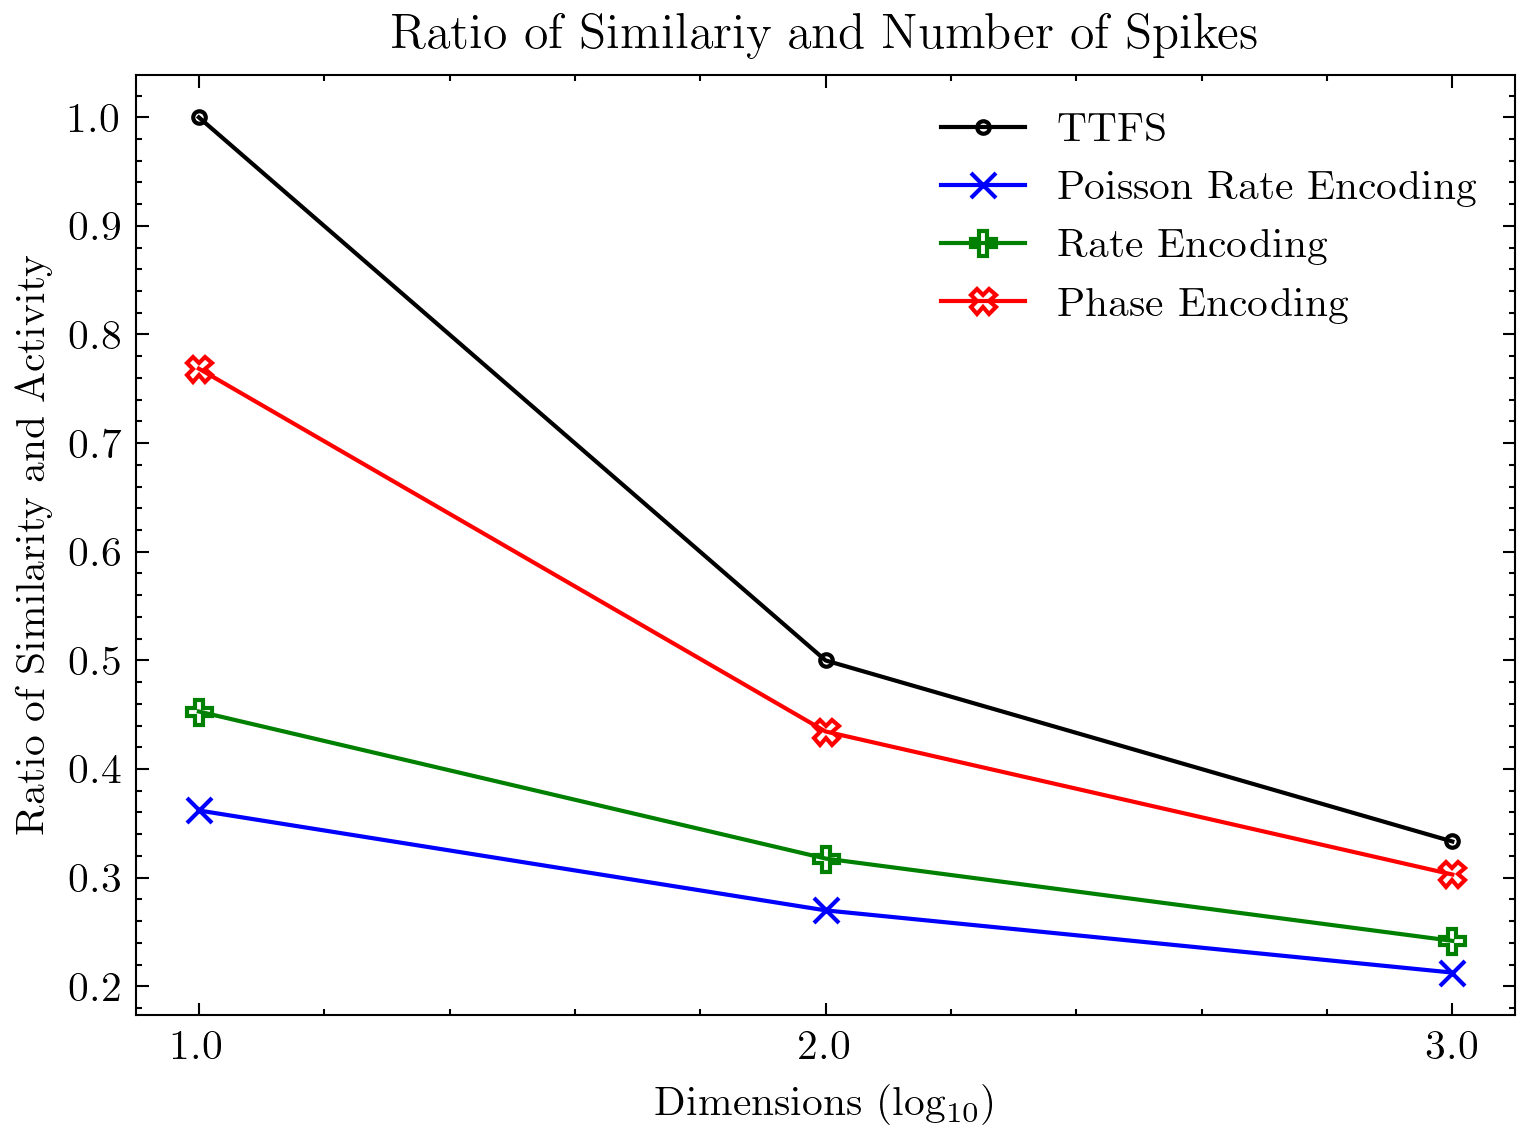

In [19]:
plot_multiple_box_plots(result, "Dimensions (log$_{10}$)", "Ratio of Similarity and Activity", "Ratio of Similariy and Number of Spikes", False, label_prefix="", figsize=(5.3,4))# x_limits=(-10,10050), y_limits=(0.9995, 1))